In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.estela import Predictor
from teslakit.climate_emulator import Climate_Emulator
from teslakit.waves import AWL, TWL, AnnualMaxima, Aggregate_WavesFamilies, Intradaily_Hydrograph
from teslakit.custom_dateutils import xds_limit_dates

from teslakit.plotting.waves import Plot_Waves_Histogram_FitSim
from teslakit.plotting.climate_emulator import Plot_Simulation
from teslakit.plotting.extremes import Plot_ReturnPeriodValidation



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/nico/Projects/TESLA-kit/TeslaKit/data'
db = Database(p_data)

# set site
db.SetSite('KWAJALEIN')


In [3]:
# --------------------------------------
# Load data for climate emulator fitting: waves partitions and families, KMA, DWT

WVS_pts = db.Load_WAVES_partitions()       # waves partitions data (hourly)
WVS_fam = db.Load_WAVES_fams_noTCs()       # wave families sea, swell_1, swell_2 (TCs removed)

KMA = db.Load_ESTELA_KMA()                 # ESTELA predictor KMA

d_WT_TCs_wvs = db.Load_WAVES_fams_TCs_categ()  # TCs-window waves-families data by category

# prepare KMA data 
DWTs_fit = xr.Dataset(
    {
        'bmus'       : ('time', KMA['sorted_bmus_storms'].values[:] + 1),
        'cenEOFs'    : (('n_clusters', 'n_features',), KMA['cenEOFs'].values[:]),
    },
    coords = {'time' : KMA['time'].values[:]}
)


# --------------------------------------
# Load data for climate emulator simulation: ESTELA DWT and TCs (MU, TAU) 

DWTs_sim = db.Load_ESTELA_DWT_sim()

TCs_params = db.Load_TCs_r2_sim_params()    # TCs parameters (copula generated) 
TCs_RBFs = db.Load_TCs_sim_r2_rbf_output()  # TCs numerical_IH-RBFs_interpolation output

probs_TCs =  db.Load_TCs_probs_synth()      # TCs synthetic probabilities
pchange_TCs = probs_TCs['category_change_cumsum'].values[:]

l_mutau_wt = db.Load_MU_TAU_hydrograms()   # MU - TAU intradaily hidrographs for each WWT
MU_WT = np.array([x.MU.values[:] for x in l_mutau_wt])  # MU and TAU numpy arrays
TAU_WT = np.array([x.TAU.values[:] for x in l_mutau_wt])


In [4]:
# --------------------------------------
# MATLAB TEST DATA OVERRIDE (year 1700-2700, DWTs bmus 1-42 + DWTs-TCs for 37-42)

from teslakit.io.matlab import ReadMatfile
from teslakit.custom_dateutils import datevec2datetime as d2d
from teslakit.custom_dateutils import DateConverter_Mat2Py as dmp

# Test data storage
p_test = op.join(p_data, 'tests', 'ClimateEmulator', 'ml_jupyter')

# load test KMA (bmus, time, number of clusters, cenEOFs)
p_bmus = op.join(p_test, 'bmus_testearpython.mat')
dm = ReadMatfile(p_bmus)

DWTs_fit = xr.Dataset(
    {
        'bmus'       : ('time', dm['KMA']['bmus']),
        'cenEOFs'    : (('n_clusters', 'n_features',), dm['KMA']['cenEOFs']),
    },
    coords = {'time' : np.array(d2d(dm['KMA']['Dates']))}
)

# DWTs (Daily Weather Types simulated using ALR) (year 1700-2700)
p_DWTs = op.join(p_test, 'DWT_1000years_mjo_awt_v2.mat')
dm = ReadMatfile(p_DWTs)

DWTs_sim = xr.Dataset(
    {
        'evbmus_sims' : (('time', 'n_sim'), dm['bmusim'].T),
    },
    coords = {'time' : dmp(dm['datesim'])}
)

# get WTs37, 42 from matlab file (TCs-window waves-families data by category)
p_WTTCs = op.join(p_test, 'KWA_waves_2PART_TCs_nan.mat')
dm = ReadMatfile(p_WTTCs)

d_WTTCs = {}
for i in range(6):

    k = 'wt{0}'.format(i+1+36)
    sd = dm[k]

    d_WTTCs['{0}'.format(i+1+36)] = xr.Dataset(
        {
            'sea_Hs'      : (('time',), sd['seaHs']),
            'sea_Dir'     : (('time',), sd['seaDir']),
            'sea_Tp'      : (('time',), sd['seaTp']),
            'swell_1_Hs'  : (('time',), sd['swl1Hs']),
            'swell_1_Dir' : (('time',), sd['swl1Dir']),
            'swell_1_Tp'  : (('time',), sd['swl1Tp']),
            'swell_2_Hs'  : (('time',), sd['swl2Hs']),
            'swell_2_Dir' : (('time',), sd['swl2Dir']),
            'swell_2_Tp'  : (('time',), sd['swl2Tp']),
        }
    )



## Climate Emulator - Fitting

In [5]:
# --------------------------------------
# Climate Emulator extremes model fitting

# climate emulator object
CE = Climate_Emulator(db.paths.site.EXTREMES.climate_emulator)

# Waves and KMA bmus data share time dimension
WVS_fam = WVS_fam.sel(time = DWTs_fit.time)
WVS_pts = WVS_pts.sel(time = DWTs_fit.time)
WVS_pts = WVS_pts.rename({'hs':'Hs', 'tp':'Tp', 'dir':'Dir'})

# Fit extremes model
config = {
    'name_fams':       ['sea', 'swell_1', 'swell_2'],
    'force_empirical': ['sea_Tp'],
}

#CE.FitExtremes(DWTs_fit, WVS_pts, WVS_fam, config)

# TODO: dev plots and complete script
CE.Load()


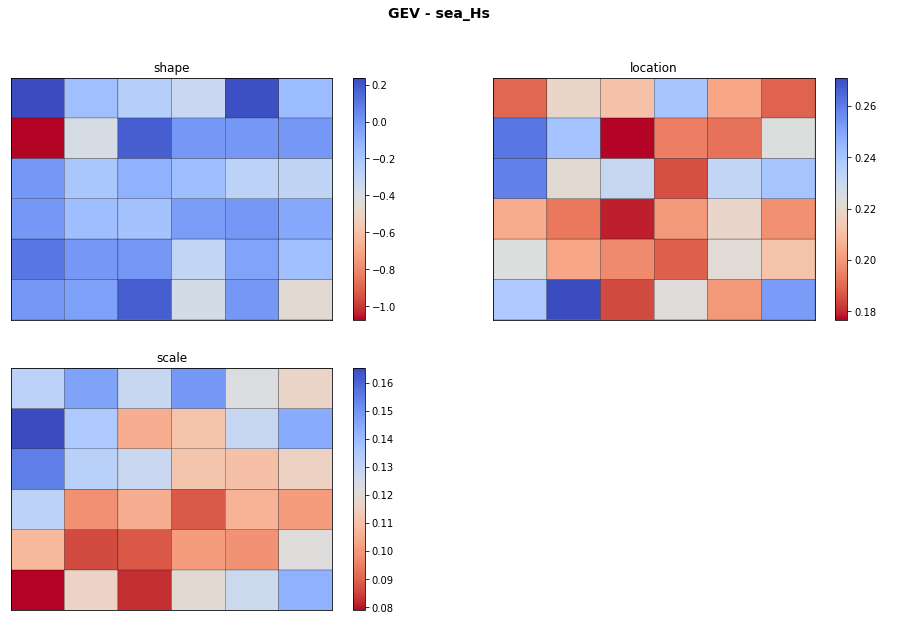

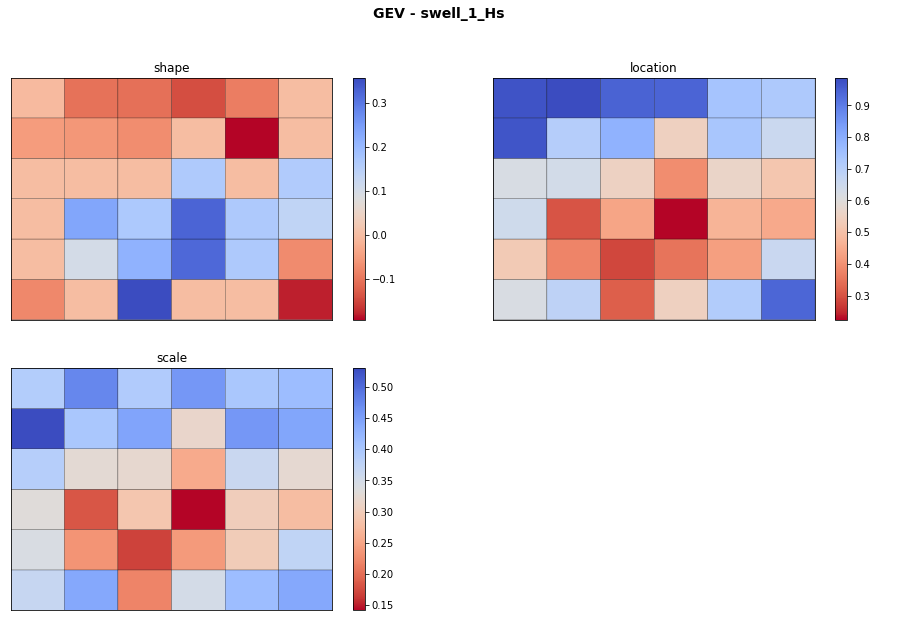

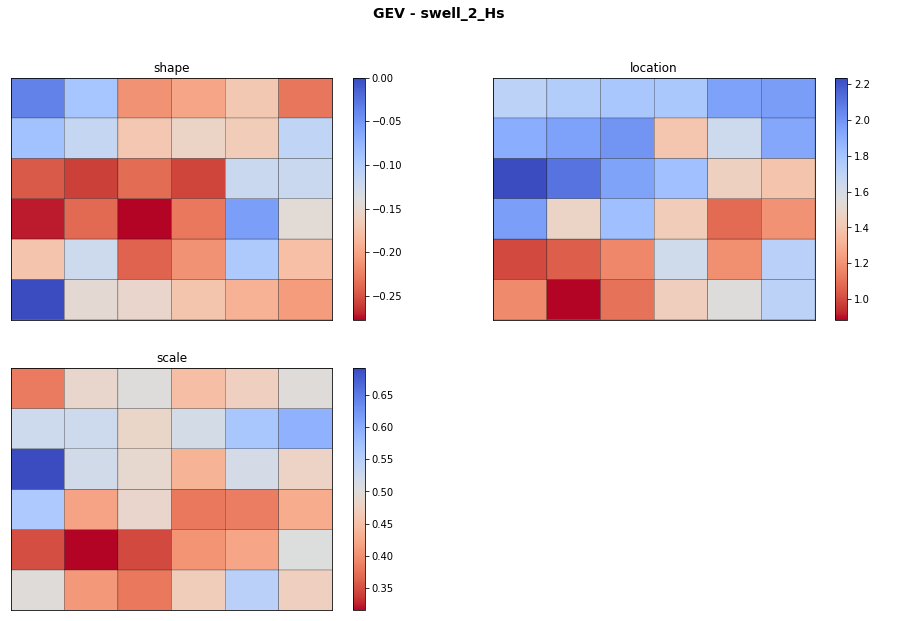

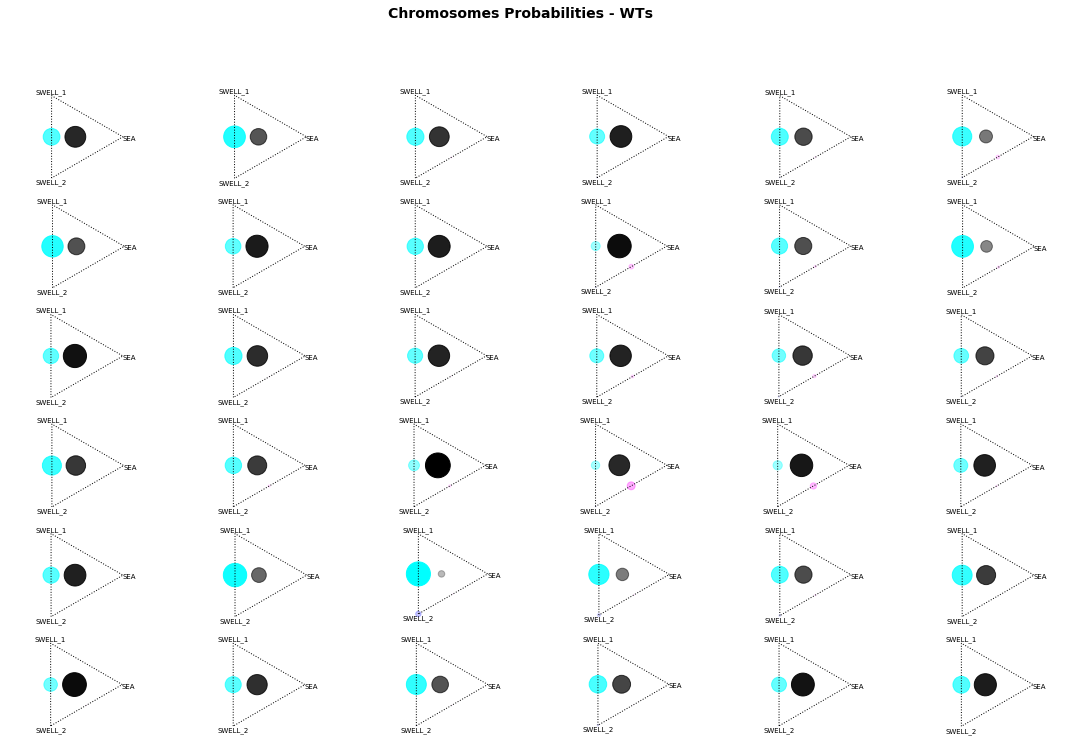

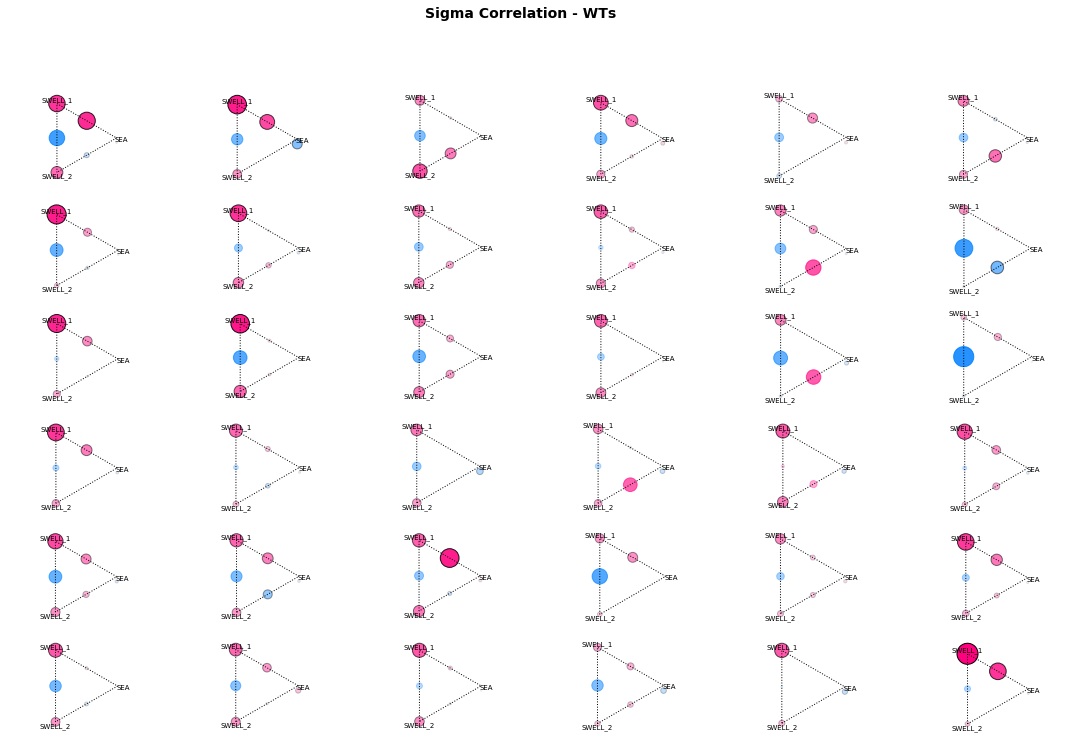

In [6]:
# Fit report figures
CE.Report_Fit();



## Climate Emulator - Simulation

In [7]:
# TODO: testing simulation period
DWTs_sim = DWTs_sim.isel(time=slice(0,100*365), n_sim=slice(0,1))
print(DWTs_sim)


<xarray.Dataset>
Dimensions:      (n_sim: 1, time: 36500)
Coordinates:
  * time         (time) object 1700-01-01 1700-01-02 ... 1799-12-06 1799-12-07
Dimensions without coordinates: n_sim
Data variables:
    evbmus_sims  (time, n_sim) uint8 22 22 17 17 17 17 17 ... 18 18 18 11 11 22


In [8]:
# --------------------------------------
#  Climate Emulator simulation (NO TCs)

# Simulate waves
#ls_wvs_sim = CE.Simulate_Waves(DWTs_sim, d_WTTCs)

# Simulate TCs and update simulated waves
#ls_tcs_sim, ls_wvs_upd = CE.Simulate_TCs(DWTs_sim, d_WTTCs, TCs_params, TCs_RBFs, pchange_TCs, MU_WT, TAU_WT)

ls_wvs_upd, ls_tcs_sim = CE.LoadSim(TCs=True)


In [9]:
# Select Simulation to solve
n_sim = 0

WVS_sim, TCS_sim = ls_wvs_upd[n_sim], ls_tcs_sim[n_sim]


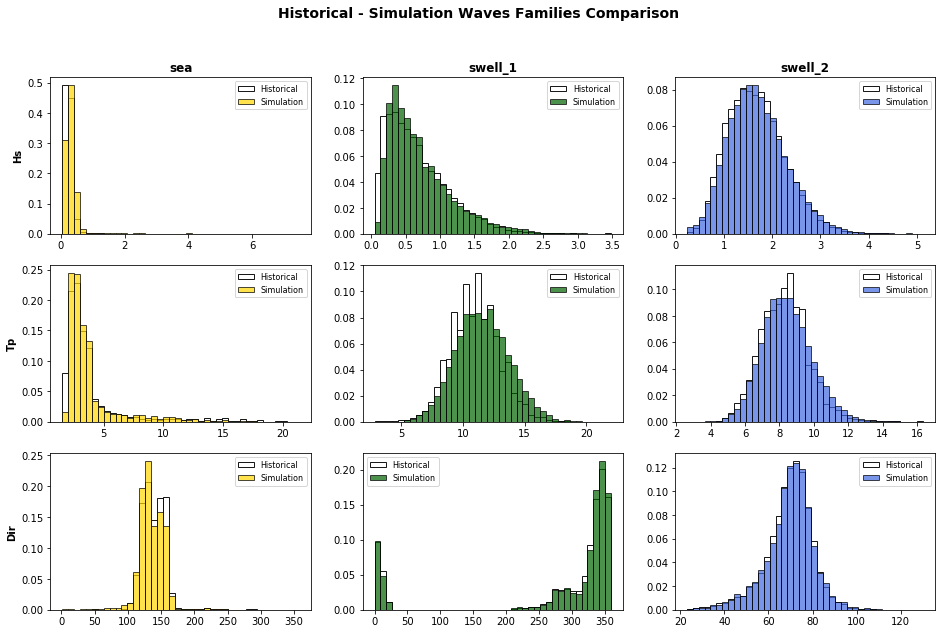

In [10]:
# Plot simulated waves parameters distribution 

Plot_Waves_Histogram_FitSim(WVS_fam, WVS_sim);
    


## Climate Emulator - Complete Output

In [11]:
# --------------------------------------
# Get all simulated data (hourly): AWTs, DWTs, MJO, MMSL, AT

DATA_sim_h = db.Load_SIM_hourly(n_sim_awt=0, n_sim_mjo=0, n_sim_dwt=0)

print(DATA_sim_h)


<xarray.Dataset>
Dimensions:  (time: 8765809)
Coordinates:
  * time     (time) object 1700-01-01 1700-01-01T01:00:00 ... 2700-01-01
Data variables:
    AWT      (time) int64 5 5 5 5 5 5 5 5 5 5 5 5 5 ... 2 2 2 2 2 2 2 2 2 2 2 2
    MJO      (time) int64 23 23 23 23 23 23 23 23 23 ... 23 23 23 23 23 23 23 24
    DWT      (time) int64 17 17 17 17 17 17 17 17 17 ... 34 34 34 34 34 34 34 17
    MMSL     (time) float32 -0.007105551 -0.007105551 ... -0.12006987
    AT       (time) float32 -0.6416192 -0.51585776 ... 0.34313485 0.29013193


In [12]:
# --------------------------------------
# TODO: MATLAB TEST DATA OVERRIDE DWTs 

DWTs_sim_h = DWTs_sim.resample(time='1H').pad()

d1, d2 = xds_limit_dates([DATA_sim_h, DWTs_sim_h])
DATA_sim_h = DATA_sim_h.sel(time = slice(d1, d2))
DWTs_sim = DWTs_sim.sel(time = slice(d1, d2))

DATA_sim_h['DWT'] = DWTs_sim_h.sel(n_sim=n_sim).evbmus_sims

print(DATA_sim_h)


<xarray.Dataset>
Dimensions:  (time: 875977)
Coordinates:
  * time     (time) datetime64[ns] 1700-01-01 1700-01-01T01:00:00 ... 1799-12-07
Data variables:
    AWT      (time) int64 5 5 5 5 5 5 5 5 5 5 5 5 5 ... 1 1 1 1 1 1 1 1 1 1 1 1
    MJO      (time) int64 23 23 23 23 23 23 23 23 23 ... 11 11 11 11 11 11 11 11
    DWT      (time) uint8 22 22 22 22 22 22 22 22 22 ... 11 11 11 11 11 11 11 22
    MMSL     (time) float32 -0.007105551 -0.007105551 ... -0.19008258
    AT       (time) float32 -0.6416192 -0.51585776 ... -0.7916626 -0.6155919


In [13]:
# --------------------------------------
#  Complete simulation 

def Simulation_Hourly(wvs_sim, tcs_sim, data_sim):
    '''
    Generate hourly simulation output. 
    
    - aggregate simulated waves storms
    - generate hourly hydrographs
    - complete output data with simulated AWTs, MJO, DWTs, AT, MMSL
    - calculates AWL and TWL
    '''
    
    # Aggregate waves families data 
    wvs_agr = Aggregate_WavesFamilies(wvs_sim)
    
    # Calculate Intradaily hourly hydrographs for simulated storms
    hy = Intradaily_Hydrograph(wvs_agr, tcs_sim)
    

    # Complete simulation output 
    d1, d2 = xds_limit_dates([hy, data_sim])
    hy = hy.sel(time = slice(d1, d2))
    dd = data_sim.sel(time = slice(d1, d2))
    hy = xr.merge([hy, dd])
    
    
    # Calculate hourly Atmospheric Water Level and Total Water Level
    hy['AWL'] = AWL(hy.Hs, hy.Tp)
    hy['TWL'] = TWL(hy.AWL, hy.SS, hy.AT, hy.MMSL)

    return hy
    
    
# Generate simulated hourly data
SIM = Simulation_Hourly(WVS_sim, TCS_sim, DATA_sim_h)
    
print(SIM)
    

<xarray.Dataset>
Dimensions:  (time: 875977)
Coordinates:
  * time     (time) datetime64[ns] 1700-01-01 1700-01-01T01:00:00 ... 1799-12-07
Data variables:
    Hs       (time) float64 0.3122 0.8216 1.331 1.309 ... 0.833 0.8224 0.8119
    Tp       (time) float64 9.716 9.716 9.716 9.716 ... 5.598 5.598 5.598 7.058
    Dir      (time) float64 71.21 71.21 71.21 71.21 ... 82.8 82.8 82.8 64.33
    SS       (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    AWT      (time) int64 5 5 5 5 5 5 5 5 5 5 5 5 5 ... 1 1 1 1 1 1 1 1 1 1 1 1
    MJO      (time) int64 23 23 23 23 23 23 23 23 23 ... 11 11 11 11 11 11 11 11
    DWT      (time) uint8 22 22 22 22 22 22 22 22 22 ... 11 11 11 11 11 11 11 22
    MMSL     (time) float32 -0.007105551 -0.007105551 ... -0.19008258
    AT       (time) float32 -0.6416192 -0.51585776 ... -0.7916626 -0.6155919
    AWL      (time) float64 0.2916 0.473 0.602 0.597 ... 0.2744 0.2727 0.3415
    TWL      (time) float64 -0.3572 -0.04999 0.3329 ... -0.6774

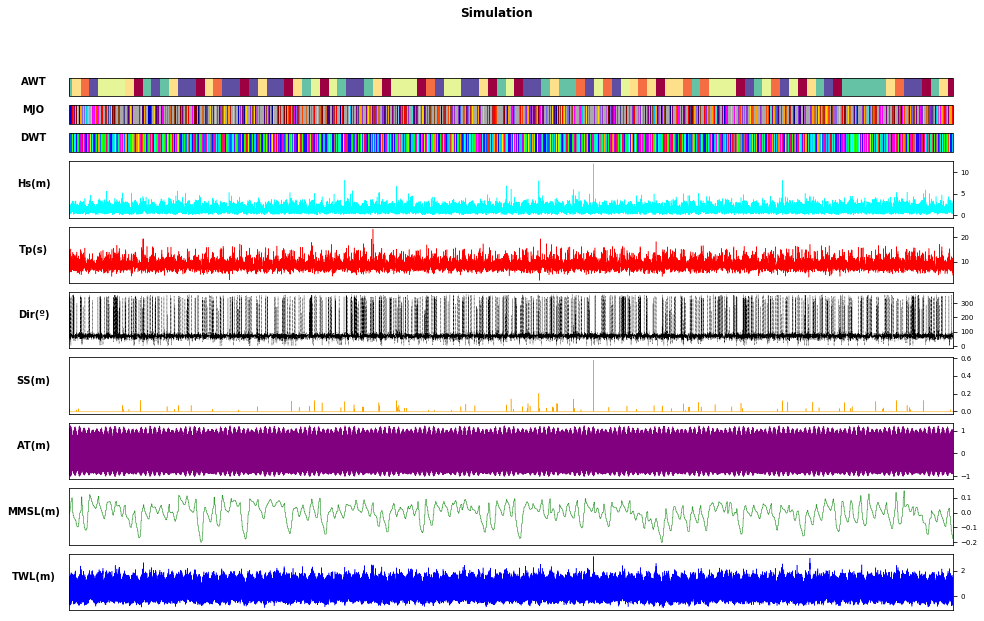

In [14]:
# Plot simulated output
Plot_Simulation(SIM);


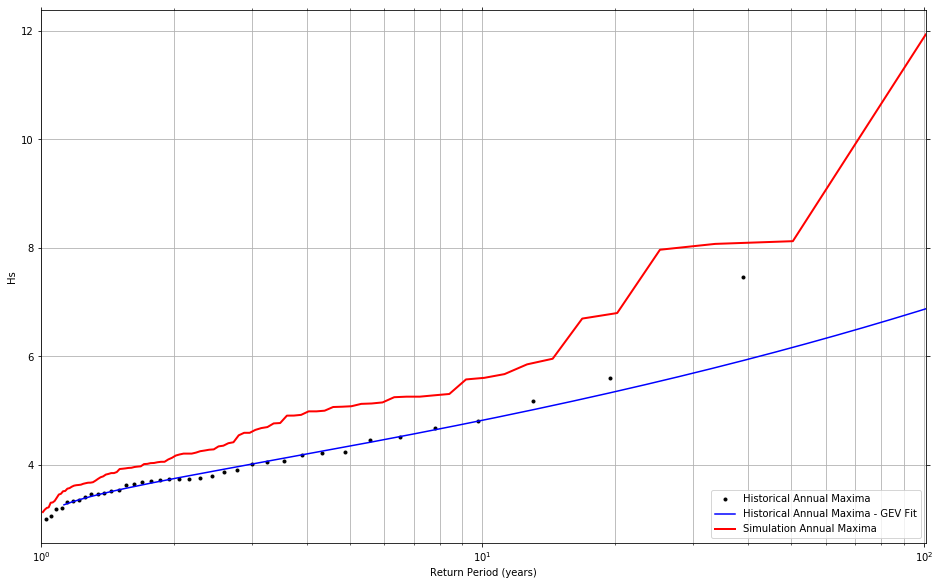

In [15]:
# --------------------------------------
#  Annual Maxima 
var_name = 'Hs'

# historical data (used to fit climate emulator)
hist_Amax = AnnualMaxima(CE.WVS_MS, var_name)

# simulation data
sim_Amax = AnnualMaxima(SIM, var_name)

# Plot Return Period
Plot_ReturnPeriodValidation(hist_Amax, sim_Amax, var_name);


In [16]:
# TODO: scatter plot Annual Maxima Fit vs Annual Maxima Simulated for all variables


